In [42]:
from Bio import SeqIO, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
import Bio.Align
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp

In [18]:
#complete these variables with the input files directory 
platform = input("where are you working (computer/laptop)?" )

#computer dir
if platform == "computer":
    dog_breeds = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\dog_breeds.fa"
    mystery_breed = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\mystery.fa"
    output = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\results"
    ind_breeds = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\individual_breed_sequences"

#laptop dir 
if platform == "laptop":
    dog_breeds = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\dog_breeds.fa"
    mystery_breed = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\mystery.fa"
    output = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\results"
    ind_breeds = r"C:\Users\User\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\individual_breed_sequences"

In [19]:
class Breed():
    """class to store information about every breed and their sequence"""
    all_instances = []
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        Breed.all_instances.append(self)  #stores all initialised sequences


In [20]:
#open the fasta file and save the sequence breed and sequence name in a Breed Class to ba sccessed at a later point 
all_breeds = set()
for record in SeqIO.parse(dog_breeds, "fasta"):
    for key in list(record.description.split("[")):  #get the description of each sequence 
        if "breed" in key and "isolate" not in key: #get breed name 
            record.name = Breed(record.seq, key[6:-2], record)
            #get a list of all the Breeds in the database
            all_breeds.add(key[6:-2])

In [21]:

#write a fasta file containing all sequences that belong to the same breed 
os.chdir(ind_breeds) # set up directory where files will be created
for breed in all_breeds: # creates a temporary variable corresponding to each individual dog breed 
    temp = breed
    file = open(breed, "w") #creates a filename eith the name of the breed in a writable format
    for key in Breed.all_instances: 
        if key.breed == temp: #itterates through all of the class instances and checks if the breedd is the same as the breed in all_breeds
            SeqIO.write(key.fasta, file, "fasta") #adds the sequence to the file 
    file.close() #once all the sequences are added file is closed


In [66]:
#create a consensus sequence for each breed 
consensus_sequences = [] #store the concensus sequences in a fasta format 
os.chdir(ind_breeds) #set directory to where the sequences are 
for file in all_breeds:
    alignments = AlignIO.parse(file, "fasta") #align all the sequences in each file
    recordname = f"{file}_consensus" #create a record name  
    #create a consensus file for all alignements
    for alignment in alignments: 
        summary = SummaryInfo(alignment) #get summary info of each alignment to create a concensus 
        consensus = summary.dumb_consensus() #create a concensus of each alignmernt 
        # Create a SeqRecord with an ID (you can customize this)
        seq_record = SeqRecord(Seq(consensus), id=recordname) #create a fasta format sequence using the consensus sequence and recordname
        consensus_sequences.append(seq_record)#add each concensus seq to a list 

C:\Users\lena1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\Bio\Align\AlignInfo.py:63: BiopythonDeprecationWarning: The `dumb_consensus` method is deprecated and will be removed in a future release of Biopython. As an alternative, you can convert the multiple sequence alignment object to a new-style Alignment object by via its `.alignment` property, and then create a Motif object. You can then use the `.consensus` or `.degenerate_consensus` property of the Motif object to get a consensus sequence. For more control over how the consensus sequence is calculated, you can call the `calculate_consensus` method on the `.counts` property of the Motif object. This is an example for a multiple sequence alignment `msa` of DNA nucleotides:
>>> from Bio.Seq import Seq
>>> from Bio.SeqRecord import SeqRecord
>>> from Bio.Align import MultipleSeqAlignment
>>> from Bio.Align.AlignInfo import SummaryInfo
>>> msa = MultipleS

In [70]:
#store concensus sequences in a results file 
concensus_filename = f"{output}/concensus_sequences"  
with open(concensus_filename, "w"):
        SeqIO.write(consensus_sequences, concensus_filename, "fasta") #adds the sequence to the file 


In [23]:
def alignment(n, mystery_sequence = mystery_breed, breed_seqs =consensus_sequences):
    """Takes in index number of the alignment score (0 being the top scoring sequence), an unknown sequence (predifined) and compares it to the database(predifined) to return the top alignment
    n is the required paramater, mystery_sequence and breed_seeqs can be substituted with a different dataset"""
    all_scores = []
    for record in SeqIO.parse(mystery_sequence, "fasta"): #get sequence from file 
        unknown_sequence = record.seq
    # Create a pairwise alignment
    aligner = Bio.Align.PairwiseAligner() 
    for record in breed_seqs: 
        score = aligner.score(record.seq, unknown_sequence) #get the alinment score of each comparasion 
        all_scores.append(score)
    all_scores.sort(reverse=True) # sort the alignment scores from highest to lowest  
    #get the n'th alignment score 
    target_score = all_scores[n]
    for record in breed_seqs:
        if aligner.score(record.seq, unknown_sequence) == target_score:
            alignment = aligner.align(record.seq, unknown_sequence)
            breed_score = (record.id).replace("_consensus", ""), record.seq, alignment[0], target_score #find out what breed and sequence is asociated withe the maximum score 
    return breed_score

In [24]:
def percentage_similarity(aln):
    """Given an alignment as aln calculates the percentage similarity between the two sequences"""
    identical_columns = float()
    #itterate through every column of the alignment
    for a in range(len(aln[0])): 
        #check if first and second sequence at column a is the same 
        if aln[0,a] == aln[1,a]: 
            #if base at position a is the same in bothe sequences add 1 to the amount of identical columns 
            identical_columns += 1
    #calculate the percentage 
    percentage = 100 * identical_columns / float(len(aln[0])) 
    #return percentage to 3dp
    return  round(percentage,3) 

In [25]:
#calculate percentage similarity of the top scoring sequence and set variable to hold the top alignment and its details 
top_percentage = percentage_similarity((alignment(0)[2]))
full_top_alignment = alignment(0)
top_alignment = full_top_alignment[2]

In [46]:
#create a file to store the top scoring alignment
filename = f"{output}/top_alignment_output"  
with open(filename, "w"):
        Bio.Align.write(top_alignment, filename, "clustal")


In [37]:
#get results aka the breed, its sequence and percentage similarity 
results = "The breed most similar to the mustery DNA file is the", full_top_alignment[0], "its percent identity is", top_percentage, "% and the breeds consensus sequence is:", full_top_alignment[1],"the alignment of the mystery dog breed and", full_top_alignment[0], "is displayed here\n", full_top_alignment[2]

#create a string representing thr results that can be written to the results file 
results_str = str()
for key in results:
    results_str += str(key) 

In [47]:
#create a file to store details about the  top alignment 
filename2 = f"{output}/top_alignment_details"  
with open(filename2, "w") as file:
        file.write(results_str)

In [55]:
#This might nbot be needed but will leave here for now 
#convert clustal alignment to a fasta file 
# Load your Clustal alignment file (replace with your actual file path)
alignment = AlignIO.read(filename, "clustal")

# Write the alignment in FASTA format 
fasta_file = f"{output}/top_alignment_fasta"  
AlignIO.write(alignment, fasta_file, "fasta")

1

In [71]:
#create a multisequence alignment between unknownn dna and all concensus sequences
# Create a MultipleSeqAlignment object
alignment = Bio.Align.MultipleSeqAlignment(consensus_sequences)
#save the multiple sequence alignment in a fasta file 


Alignment with 39 rows and 16735 columns
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Azores Cattle dog_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Portuguese Pointing Dog_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Portuguese Sheepdog_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Castro Laboreiro Watchdog_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Husky_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Shar Pei_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA German Shepherd cross_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Great Dane cross_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA English Springer Spaniel_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA EpagneulBreton_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Estrela Mountain dog_consensus
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAA...TAA Algarve Barrocal Dog_consensus
GTT

In [75]:
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo

# Calculate the distance matrix
calculator = DistanceCalculator("identity")
distance_matrix = calculator.get_distance(alignment)

# Build the tree using the neighbor-joining method
constructor = DistanceTreeConstructor(calculator, method="nj")
tree = constructor.build_tree(alignment)

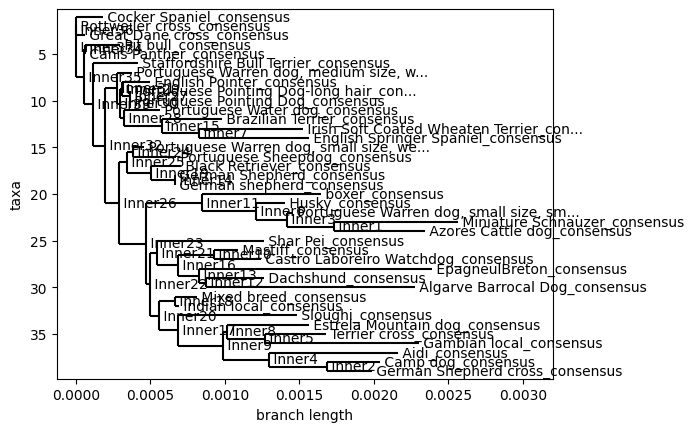

In [123]:
t =Phylo.draw(tree)